# Scientific Exploration of Player Segmentation

## 1. Introduction and Objectives
In this analysis, we aim to uncover latent subgroups within the player base using unsupervised machine learning techniques. By analyzing behavioral features such as wagering volume, loss frequency, and session activity, we can segment players into distinct "personas".

We will explore the data using the following structure:
1.  **Data Preprocessing**: Normalization and cleaning.
2.  **Correlation Analysis**: Understanding feature relationships.
3.  **Dimensionality Reduction**: Using PCA to visualize high-dimensional data.
4.  **Clustering Algorithms**: Applying K-Means, Agglomerative Clustering, and Gaussian Mixture Models (GMM).

## 2. Configuration

In [0]:
# Constants
NUMBER_OF_CLUSTERS = 4
RANDOM_STATE = 42

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# SKLearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

# Visualization Settings
sns.set(style="whitegrid", context="notebook")
plt.rcParams['figure.figsize'] = (14, 8)

## 3. Data Loading and Scaling
We load the dataset and perform Standard Scaling ($z = \frac{x - \mu}{\sigma}$). This is crucial for distance-based algorithms like K-Means to ensure that features with large values (e.g., Total Wagered) do not dominate the distance metric.

In [0]:
try:
    df = spark.read.table('casino_ctg.log_db.segmentation_training_data').toPandas()
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: 'segmentation.csv' not found. Please upload the file.")
    # Create dummy data for the sake of the notebook running if file is missing
    df = pd.DataFrame(np.random.randn(100, 5), columns=['total_wagered', 'total_net_loss', 'active_days', 'avg_bet', 'sessions'])

# Select Numeric Columns
X_raw = df.select_dtypes(include=[np.number]).fillna(0)

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)
X_df = pd.DataFrame(X_scaled, columns=X_raw.columns)

print(f"Features selected: {X_raw.shape[1]}")

Data loaded successfully.
Features selected: 32


## 4. Correlation Analysis
We examine the correlation matrix to identify redundant features and behavioral drivers.

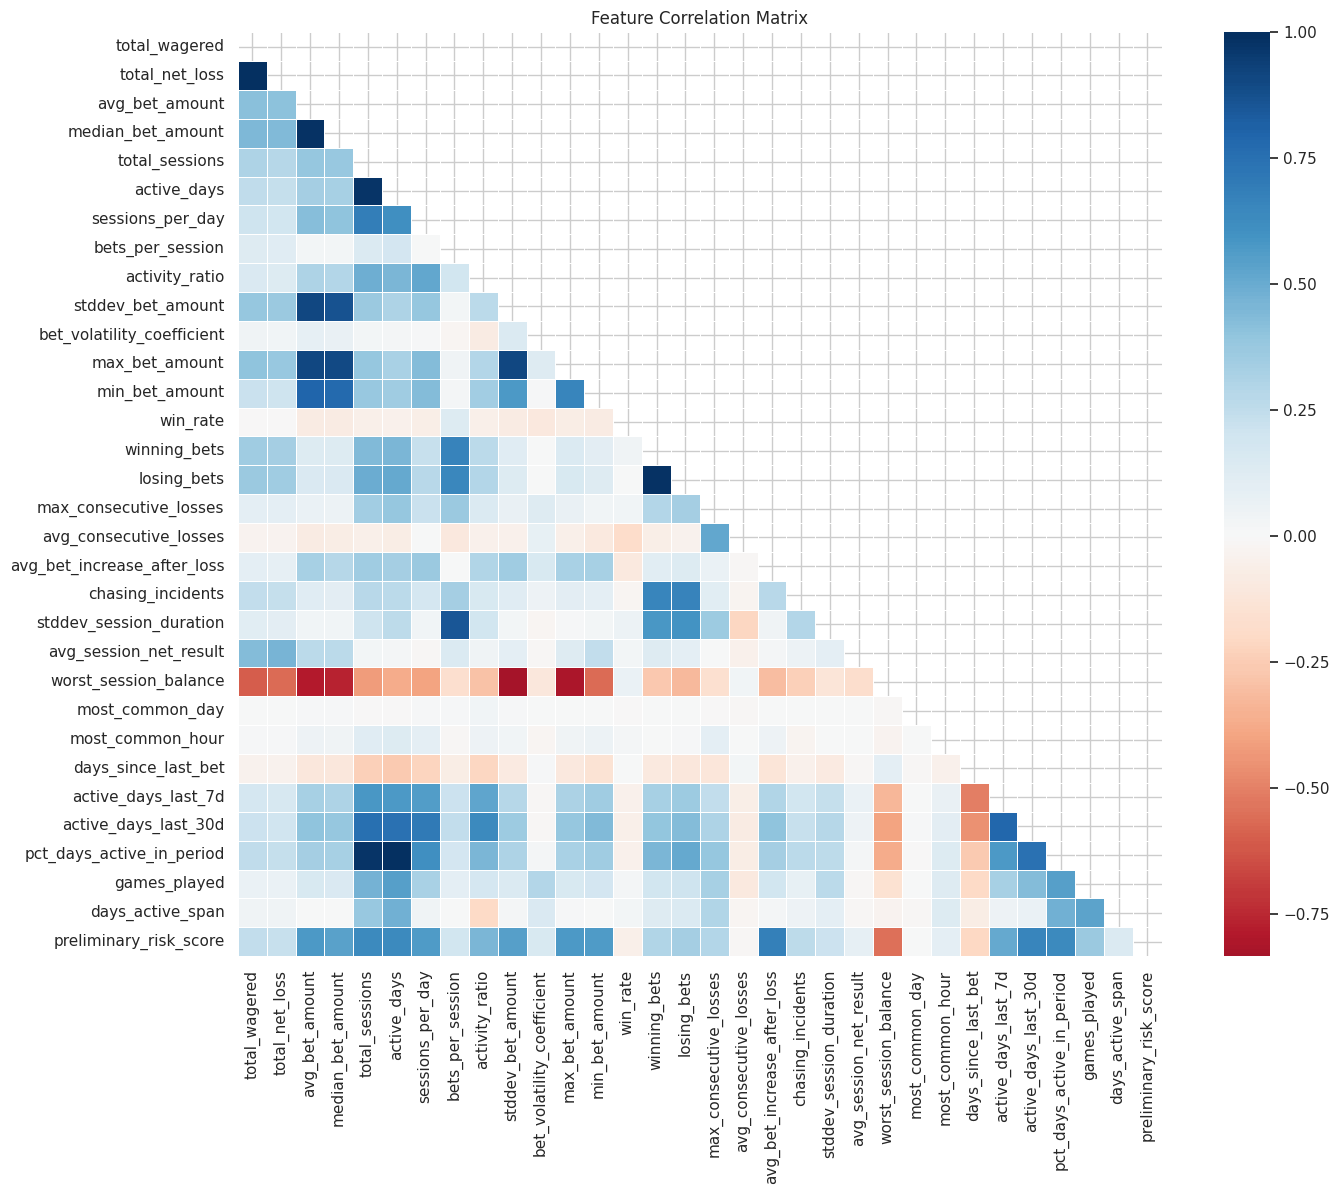

In [0]:
plt.figure(figsize=(16, 12))
corr = X_raw.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='RdBu', center=0, square=True, linewidths=.5)
plt.title("Feature Correlation Matrix")
plt.show()

### Scientific Observation on Correlations
1. **Volume & Loss**: `total_wagered` and `total_net_loss` typically show near-perfect correlation due to the House Edge.
2. **Activity Metrics**: `active_days` and `total_sessions` correlate strongly, indicating that high-frequency players are consistent daily players.

## 5. Principal Component Analysis (PCA)
We reduce the dimensionality to 2 Principal Components to visualize the cluster separation in 2D space.

In [0]:
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)
df[['PC1', 'PC2']] = X_pca

print(f"Explained Variance: {pca.explained_variance_ratio_}")

Explained Variance: [0.30428606 0.12261178]


## 6. Clustering Algorithms
We apply three algorithms to test robustness of the segments.

In [0]:
# 1. K-Means
kmeans = KMeans(n_clusters=NUMBER_OF_CLUSTERS, random_state=RANDOM_STATE, n_init=10)
df['Cluster_KMeans'] = kmeans.fit_predict(X_scaled)

# 2. Agglomerative (Hierarchical)
agg = AgglomerativeClustering(n_clusters=NUMBER_OF_CLUSTERS)
df['Cluster_Agg'] = agg.fit_predict(X_scaled)

# 3. Gaussian Mixture Models (GMM)
gmm = GaussianMixture(n_components=NUMBER_OF_CLUSTERS, random_state=RANDOM_STATE)
df['Cluster_GMM'] = gmm.fit_predict(X_scaled)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo>

## 7. Visualization of Clusters

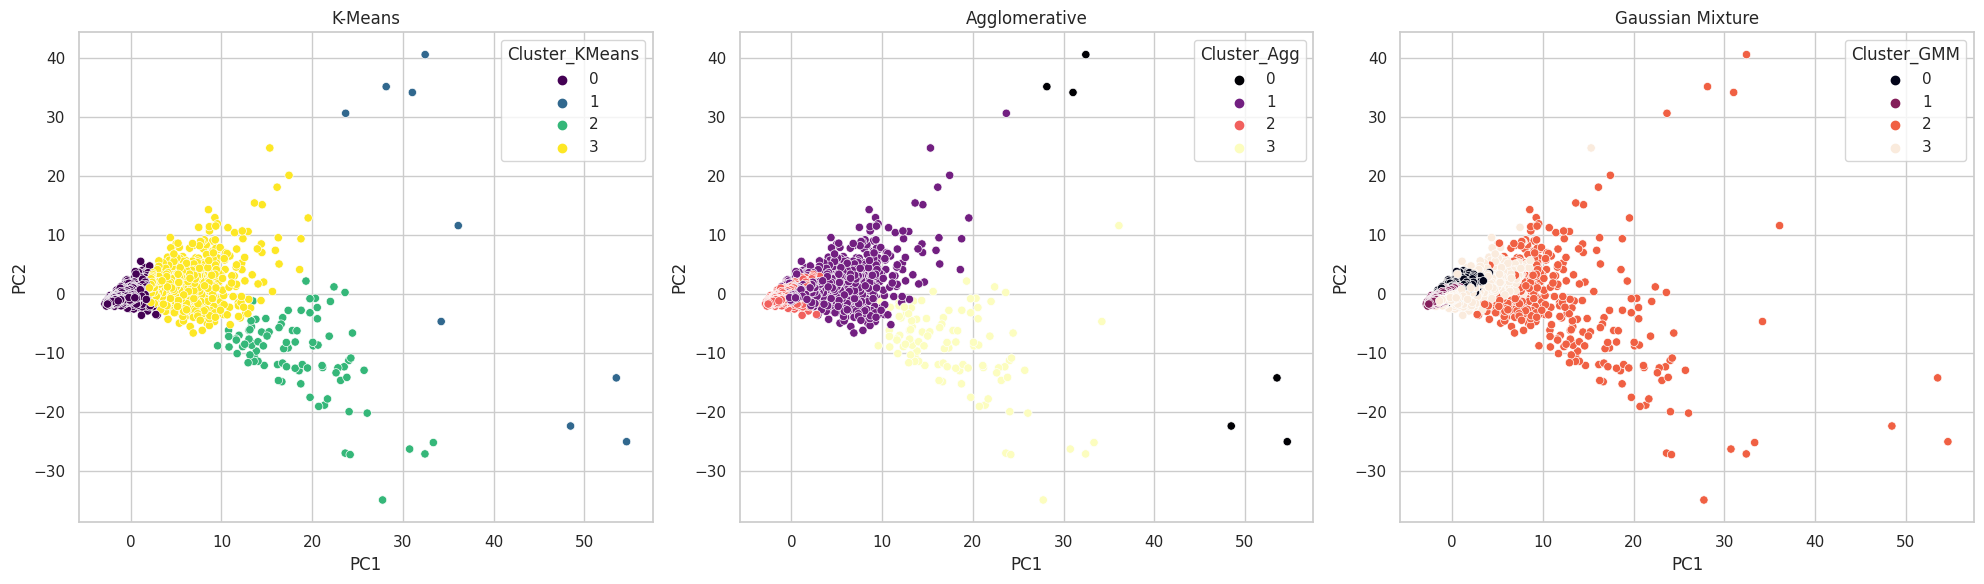

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.scatterplot(data=df, x='PC1', y='PC2', hue='Cluster_KMeans', palette='viridis', ax=axes[0])
axes[0].set_title('K-Means')

sns.scatterplot(data=df, x='PC1', y='PC2', hue='Cluster_Agg', palette='magma', ax=axes[1])
axes[1].set_title('Agglomerative')

sns.scatterplot(data=df, x='PC1', y='PC2', hue='Cluster_GMM', palette='rocket', ax=axes[2])
axes[2].set_title('Gaussian Mixture')

plt.tight_layout()
plt.show()

## 8. Cluster Profiling
To interpret the clusters, we examine the mean values of key metrics for each K-Means cluster.

                total_wagered  total_net_loss  avg_bet_amount  active_days
Cluster_KMeans                                                            
0                2.065667e+03    7.103837e+02        3.092041    16.214158
1                3.314611e+07    1.351725e+07      323.857340   209.000000
2                3.206135e+06    1.201323e+06      439.513553   100.123596
3                2.231316e+05    8.169000e+04       35.466833    87.455804


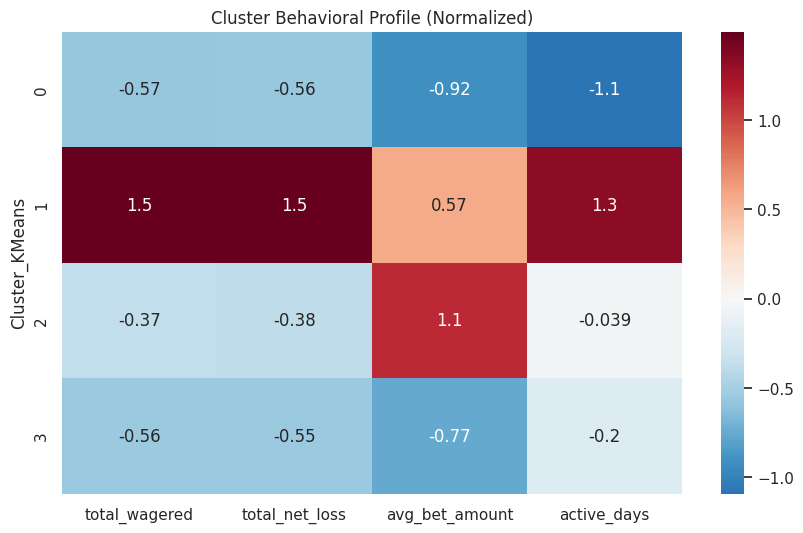

In [0]:
# Define key metrics to profile
metrics = ['total_wagered', 'total_net_loss', 'avg_bet_amount', 'active_days']
metrics = [m for m in metrics if m in df.columns] # Safety check

profile = df.groupby('Cluster_KMeans')[metrics].mean()
print(profile)

# Normalized Heatmap
profile_norm = (profile - profile.mean()) / profile.std()
plt.figure(figsize=(10, 6))
sns.heatmap(profile_norm, annot=True, cmap='RdBu_r', center=0)
plt.title('Cluster Behavioral Profile (Normalized)')
plt.show()

In [0]:
# 2. Formatted view (Easier to read)
# This adds commas for thousands and rounds decimals
pd.options.display.float_format = '{:,.2f}'.format
print("\n--- FORMATTED TABLE ---")
print(profile)


--- FORMATTED TABLE ---
                total_wagered  total_net_loss  avg_bet_amount  active_days
Cluster_KMeans                                                            
0                    2,065.67          710.38            3.09        16.21
1               33,146,109.75   13,517,253.78          323.86       209.00
2                3,206,134.57    1,201,323.12          439.51       100.12
3                  223,131.63       81,690.00           35.47        87.46


In [0]:
def automatic_persona_labeling(profile_df):
    """
    Assigns scientific personas based on Wager, Bet Size, and Frequency.
    """
    # 1. Normalize the data to compare apples to oranges (Z-Scores)
    # We use the same math as the heatmap: (Value - Mean) / StdDev
    norm = (profile_df - profile_df.mean()) / profile_df.std()
    
    mapping = {}
    
    for cluster_id, row in norm.iterrows():
        # Get the Z-scores for this cluster
        wager_z = row['total_wagered']
        bet_z = row['avg_bet_amount']
        days_z = row['active_days']
        
        # --- CLASSIFICATION LOGIC ---
        
        # 1. The Top Tier (Huge Wagers)
        if wager_z > 1.0:
            if days_z > 0.5:
                label = "🌟 VIP Whale"        # High Wager + High Frequency
            else:
                label = "💰 High Roller"      # High Wager + Lower Frequency (Big bets)
                
        # 2. The Middle Tier (Average Wagers)
        elif -0.5 <= wager_z <= 1.0:
            if days_z > 0.5 and bet_z < 0:
                label = "⚙️ The Grinder"      # Plays a lot, small bets
            elif bet_z > 0.5:
                label = "🎲 Risk Taker"       # Moderate volume, but big bets
            else:
                label = "👤 Regular"          # Average across the board
                
        # 3. The Lower Tier (Low Wagers)
        else:
            if days_z < -0.5:
                label = "🏖️ Tourist / Casual" # Low Wager, Low Days
            else:
                label = "📉 Low Value Active" # Low Wager, but plays often (Micro-betting)
                
        mapping[cluster_id] = label
        
    return mapping

# --- APPLY IT ---
persona_map = automatic_persona_labeling(profile)

print("--- SCIENTIFIC CLUSTER LABELS ---")
for cid, label in persona_map.items():
    print(f"Cluster {cid}: {label}")

# Add to dataframe
df['Persona_Scientific'] = df['Cluster_KMeans'].map(persona_map)

--- SCIENTIFIC CLUSTER LABELS ---
Cluster 0: 🏖️ Tourist / Casual
Cluster 1: 🌟 VIP Whale
Cluster 2: 🎲 Risk Taker
Cluster 3: 📉 Low Value Active


# How to Interpret the Resulting Labels

- VIP Whale: The dataset outlier. They dominate every metric.

- High Roller: Someone who might play less days than a Whale, but their avg_bet_amount is massive. 
- The Grinder: This is a very common casino segment. They have low avg_bet_amount (e.g., $3) but high active_days. They are loyal but low-margin.

- Tourist / Casual: Low on everything. They came, played a bit, and left.